In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset

import pytorch_lightning as pl

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

from db.db import init_db, get_stocks

from model.predictor import LitLSTMModel

from helpers.plots import data_plot

from tickers import TICKERS

In [3]:
await init_db()

In [4]:

df = await get_stocks(TICKERS[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8609 entries, 1990-01-02 to 2024-03-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  8609 non-null   object 
 1   open    8609 non-null   float64
 2   high    8609 non-null   float64
 3   low     8609 non-null   float64
 4   close   8609 non-null   float64
 5   volume  8609 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 470.8+ KB


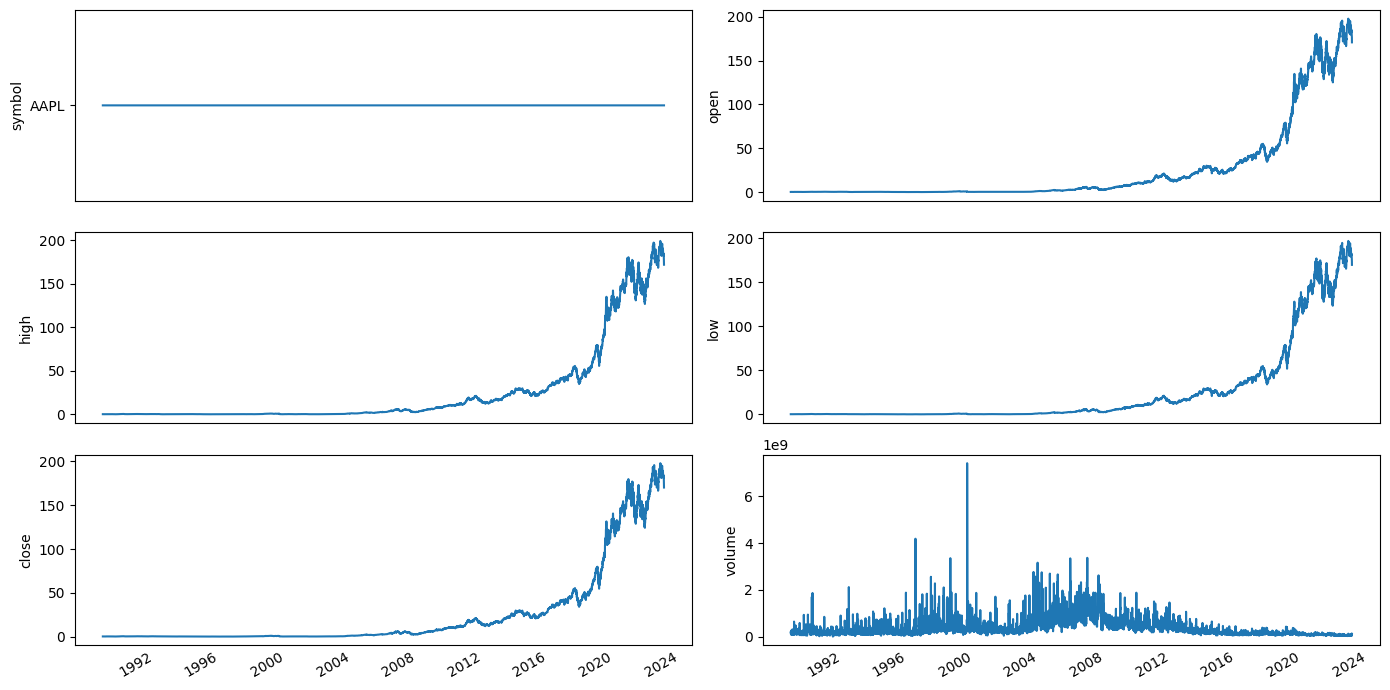

In [5]:
data_plot(df)

In [6]:
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

print(categorical_columns)
print(numerical_columns)

# Drop the symbol column
df = df.drop(['symbol'], axis=1)

Index(['symbol'], dtype='object')
Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')


In [7]:
train, test = train_test_split(df, test_size=0.2, shuffle=False)

train, test = train['open'], test['open']
print(train.shape, test.shape)

(6887,) (1722,)


In [8]:
# Scale the data per symbol
scaler = MinMaxScaler((0, 1))
scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
scaled_test = scaler.fit_transform(test.values.reshape(-1, 1))

print(scaled_train.shape, scaled_test.shape)

(6887, 1) (1722, 1)


In [9]:
# Create a tensor of size window size for each sample
def create_sequences(X, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(X[i+1:i+window_size+1])
    return np.array(Xs), np.array(ys)

In [10]:
# Create sequences for the train data
seq_length = 50
X_train, y_train = create_sequences(scaled_train, window_size=seq_length)

# Convert to tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

# Create sequences for the test data
seq_length = 30
X_test, y_test = create_sequences(scaled_test, window_size=seq_length)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([6837, 50, 1]) torch.Size([6837, 50, 1])
torch.Size([1692, 30, 1]) torch.Size([1692, 30, 1])


In [11]:
# Define the model
input_size = X_train.shape[2]
num_layers = 2
hidden_layer_size = 64

model = LitLSTMModel(input_size, hidden_layer_size, num_layers)
print(type(model))
trainer = pl.Trainer(limit_train_batches=100, max_epochs=10, min_epochs=3, gradient_clip_val=0.5, deterministic=True)

<class 'model.predictor.LitLSTMModel'>


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/manuel/Projects/StockPredictor/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [12]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)

# Train the model
trainer.fit(model, train_loader, val_loader)


  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 50.4 K
1 | linear | Linear | 65    
----------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)


/home/manuel/Projects/StockPredictor/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/manuel/Projects/StockPredictor/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 49.33it/s, v_num=24, train_loss=2.53e-5, val_loss=0.00019]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 49.14it/s, v_num=24, train_loss=2.53e-5, val_loss=0.00019]


In [13]:
# Define the number of future time steps to forecast
num_forecast_steps = 30

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float()
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])

        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value


# Generate futute dates
last_date = test.index[-1]

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

# Concatenate the original index with the future dates
combined_index = test.index.append(future_dates)

/tmp/ipykernel_71412/3862684022.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


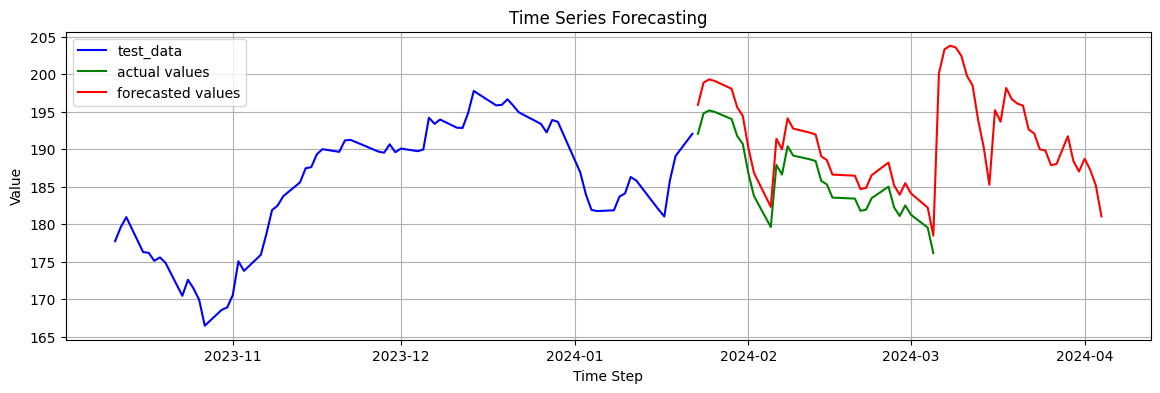

In [14]:
#set the size of the plot
plt.rcParams['figure.figsize'] = [14, 4]

#Test data
plt.plot(test.index[-100:-30], test.values[-100:-30], label = "test_data", color = "b")
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()

#the historical data used as input for forecasting
plt.plot(test.index[-30:], original_cases, label='actual values', color='green')

#Forecasted Values
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
# plotting the forecasted values
plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)